In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

# 1. Read and Understand The Data

In [3]:
country = pd.read_csv('Country-data.csv')
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
country.shape

(167, 10)

In [5]:
country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [6]:
country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

Data contains no missing values

In [7]:
country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,41.108976,6.815689,46.890215,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,27.412010,2.746837,24.209589,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,0.109000,1.810000,0.065900,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,23.800000,4.920000,30.200000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,35.000000,6.320000,43.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,51.350000,8.600000,58.750000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,200.000000,17.900000,174.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


exports, health and imports column is represented as a percentage of gdpp. As the gdp of every country varies a lot, we will convert the columns export, health and imports to absolute values instead of percentages

# 2. Data Cleaning and Preparation for Modelling

In [8]:
# Converting the columns exports, health and imports from percentage to actual numbers
country['exports'] = (country['exports']*country['gdpp'])/100
country['health'] = (country['health']*country['gdpp'])/100
country['imports'] = (country['imports']*country['gdpp'])/100

In [9]:
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


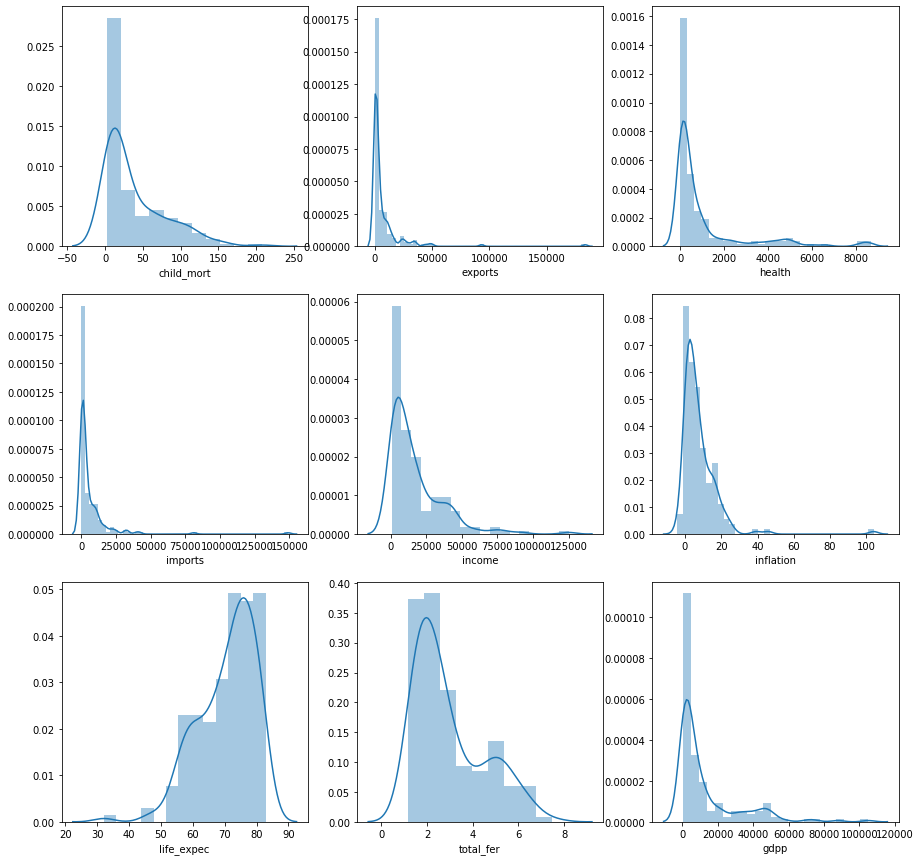

In [10]:
#check the distribution of each columns - univariate analysis
plt.figure(figsize = (15,15))
feature = country.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.distplot(country[i[1]])

## 2.1: Outlier Treatment

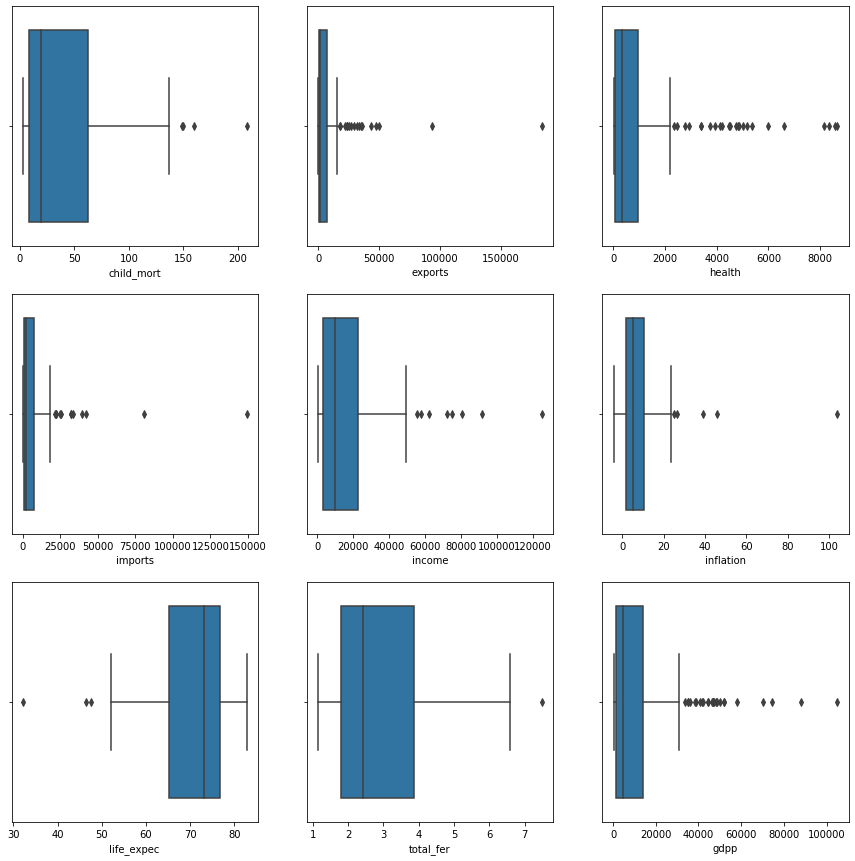

In [11]:
# Check the columns having outliers using box plot
plt.figure(figsize = (15,15))
feature = country.columns[1:]
for i in enumerate(feature):
    plt.subplot(3,3, i[0]+1)
    sns.boxplot(country[i[1]])

All the columns contain outliers. As we have to find out the countries which are in the direst need of aid, we cannot just remove the outliers. Outlier must be capped depending upon the column. We consider, if child_mort is high, then the country needs immediate aid. So this column will not be capped for extremely high value outliers. 
My approach here is to cap the high value outliers for each column except child_mort.

In [12]:
# Capping
feature = country.columns[2:]
for i in enumerate(feature):
    q4 = country[i[1]].quantile(0.95)
    country[i[1]][country[i[1]] >= q4] = q4

## 2.2: Scaling

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df = scaler.fit_transform(country.drop('country', axis = 1))
df

array([[ 1.29153238, -0.66958102, -0.62943544, ..., -1.62318027,
         2.01642065, -0.75736169],
       [-0.5389489 , -0.54217181, -0.47348864, ...,  0.65482341,
        -0.88053487, -0.52332107],
       [-0.27283273, -0.47583812, -0.53001667, ...,  0.67749012,
        -0.01909006, -0.49883845],
       ...,
       [-0.37231541, -0.56578559, -0.59652699, ...,  0.29215616,
        -0.6721208 , -0.70727157],
       [ 0.44841668, -0.63010392, -0.61153387, ..., -0.34251153,
         1.21750006, -0.70727157],
       [ 1.11495062, -0.61289625, -0.59901824, ..., -2.09918104,
         1.72464096, -0.69734618]])

In [14]:
# Checking the dataset post scaling
df = pd.DataFrame(df, columns=country.columns[1:])
df.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,1.291532,-0.669581,-0.629435,-0.732729,-0.958349,0.394438,-1.623180,2.016421,-0.757362
1,-0.538949,-0.542172,-0.473489,-0.472182,-0.394006,-0.383226,0.654823,-0.880535,-0.523321
2,-0.272833,-0.475838,-0.530017,-0.560152,-0.192552,1.440750,0.677490,-0.019090,-0.498838
3,2.007808,-0.418960,-0.588935,-0.543087,-0.667360,2.190136,-1.181180,2.044904,-0.560376
4,-0.695634,-0.027134,-0.150685,0.306422,0.227992,-0.862393,0.711490,-0.547072,0.013312


## 2.3: Check The Hopkins Statistic

In [15]:
# Check the hopkins

#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [16]:
hopkins(df)

0.8443558723803412

Hopkins statistic is more than 0.80, that shows the formation of cluster tendecy is good

# 3. K- Means Clustering 
## 3.1: Finding The Optimal number of Clusters
### 3.1.1: Elbow Curve Method (SSD)

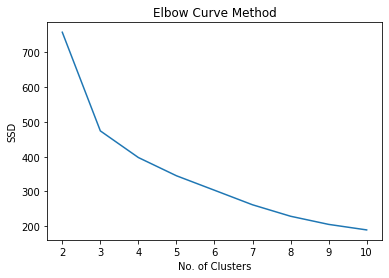

In [17]:
ssd = []
for num_clusters in range(2,11):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df)
    ssd.append([num_clusters,kmeans.inertia_])
temp = pd.DataFrame(ssd)
plt.title('Elbow Curve Method')
plt.xlabel('No. of Clusters')
plt.ylabel('SSD')
plt.plot(temp[0],temp[1])

### 3.1.2: Silhouette Analysis

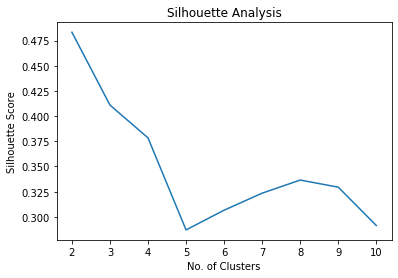

In [18]:
sa = []
for num_clusters in range(2,11):
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(df)
    sa.append([num_clusters,silhouette_score(df,kmeans.labels_)])
temp = pd.DataFrame(sa)
plt.title('Silhouette Analysis')
plt.xlabel('No. of Clusters')
plt.ylabel('Silhouette Score')
plt.plot(temp[0], temp[1])

## 3.2: K-Means Modelling

In [19]:
# final model with k=3
kmeans = KMeans(n_clusters=3, random_state=50)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [20]:
kmeans.labels_

array([2, 1, 1, 2, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 0, 1, 2, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0, 0,
       0, 1, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 2, 1, 0, 2, 0, 1, 1, 2, 2, 1,
       2, 1, 0, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 1, 2,
       2, 1, 1, 0, 1, 2, 2, 1, 1, 2, 0, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1,
       0, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2, 1, 1,
       2, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 1, 0, 0, 1, 2, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2])

In [21]:
# assign the label
country['cluster_id'] = kmeans.labels_
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.820,553,2
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090,1
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460,1
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530,2
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200,1


## 3.3: Visualization on The Cluster

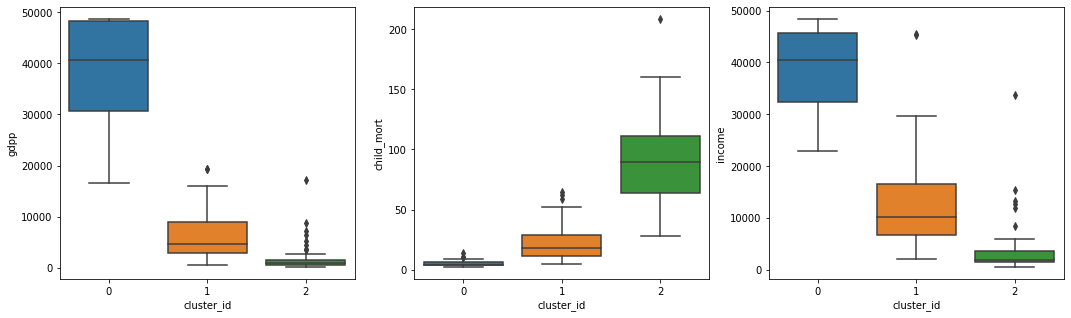

In [22]:
plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
sns.boxplot(x = 'cluster_id',y = 'gdpp', data=country)
plt.subplot(1,3,2)
sns.boxplot(x = 'cluster_id',y = 'child_mort', data=country)
plt.subplot(1,3,3)
sns.boxplot(x = 'cluster_id',y = 'income', data=country)
plt.show()

- Cluster 0 contains countries with high gdpp, low child_mort and high income.
- Cluster 1 contains countries with low gdpp, medium child_mort and medium income.
- Cluster 2 contains countries with the lowest gdpp, highest child_mort and the lowest income.


So, the countries in cluster 2 are in the direst need of aid

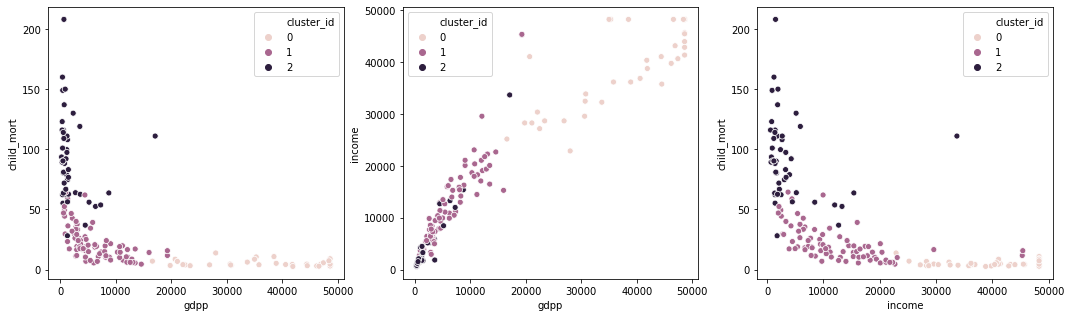

In [23]:
plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
sns.scatterplot(x='gdpp',y='child_mort',hue = 'cluster_id', data=country)
plt.subplot(1,3,2)
sns.scatterplot(x='gdpp',y='income',hue = 'cluster_id', data=country)
plt.subplot(1,3,3)
sns.scatterplot(x='income',y='child_mort',hue = 'cluster_id', data=country)
plt.show()

## 3.4: Cluster Profiling

In [24]:
country['cluster_id'].value_counts()

1    82
2    48
0    37
Name: cluster_id, dtype: int64

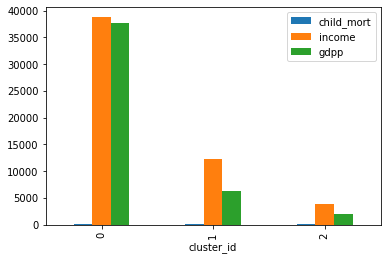

In [25]:
country[['child_mort','income','gdpp']].groupby(country['cluster_id']).mean().plot(kind = 'bar')

In [26]:
country[country['cluster_id'] == 2].sort_values(by = ['gdpp','child_mort','income'], ascending = [True,False,True]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,5.861,231,2
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.020,327,2
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,5.861,334,2
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,5.861,348,2
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.200,399,2


## 3.5: Conclusion from K-Means Clustering

The five countries which are in the direst need of aid are the countries having the lowest gdpp, highest child_mort and the lowest income. Those 5 countries are as follows.
- Burundi
- Liberia
- Congo, Dem. Rep.
- Niger
- Sierra Leone

# 4. Hierarchical Clustering
## 4.1: Create Dendrograms Using Single and Complete Linkage

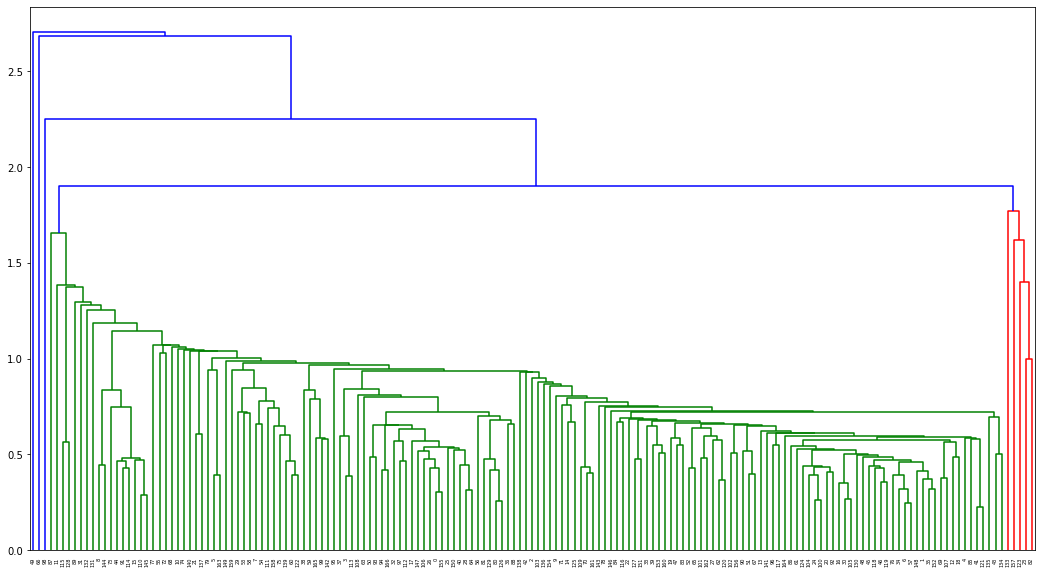

In [27]:
# Single Linkage
plt.figure(figsize=(18,10))
mergings = linkage(df, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

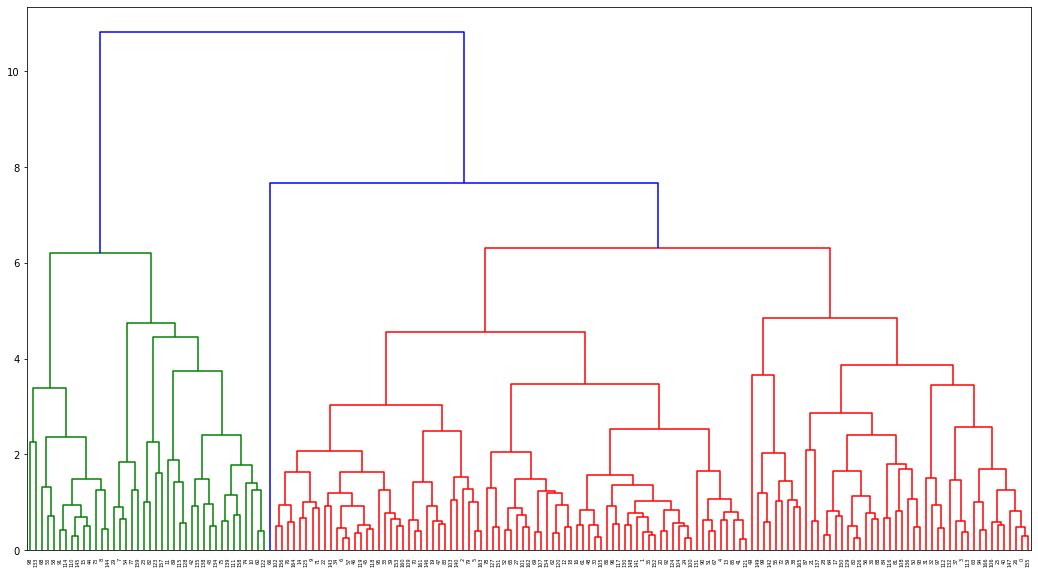

In [28]:
# Complete Linkage
plt.figure(figsize=(18,10))
mergings = linkage(df, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

Complete linkage dendrograms seems to easily interpretable and clear. Looking at the height of the dendrograms, the optimal number of clusters will be 3.

In [29]:
# Create 3 clusters by cutting the dendrogram
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [30]:
# assign cluster labels
country['cluster_labels'] = cluster_labels
country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,Afghanistan,90.2,55.30,41.9174,248.297,1610.0,9.44,56.2,5.820,553,2,0
1,Albania,16.6,1145.20,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090,1,0
2,Algeria,27.3,1712.64,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460,1,0
3,Angola,119.0,2199.19,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530,2,0
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200,1,0


## 4.2: Visualization on The Clusters

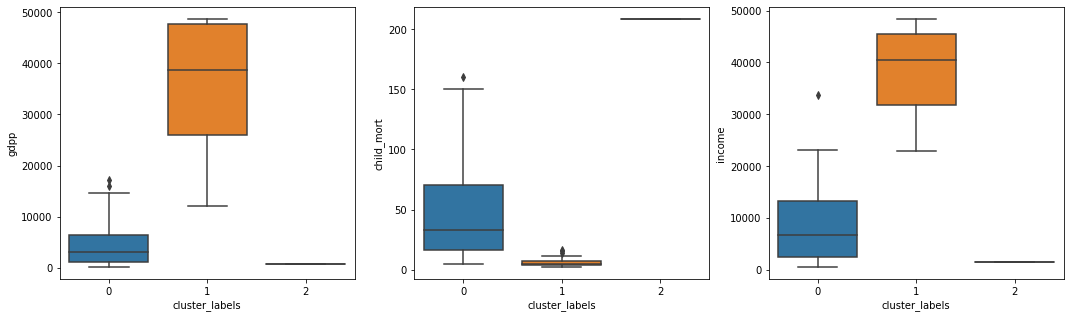

In [31]:
plt.figure(figsize = (18,5))
plt.subplot(1,3,1)
sns.boxplot(x = 'cluster_labels',y = 'gdpp', data=country)
plt.subplot(1,3,2)
sns.boxplot(x = 'cluster_labels',y = 'child_mort', data=country)
plt.subplot(1,3,3)
sns.boxplot(x = 'cluster_labels',y = 'income', data=country)
plt.show()

- Cluster 0 contains countries with very low gdpp,high child_mort and low income.
- cluster 1 contains countries with high income, low child_mort and high income.
- cluster 2 contains countries with low gdpp, highest child_mort and very low income. It seems cluster 2 contains less number of data points also. We will check that in the later steps.

So cluster 0 and cluster 2 are in the direst need of aid

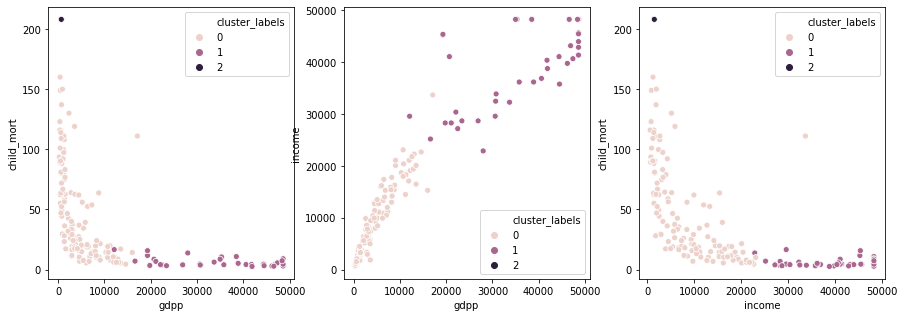

In [32]:
plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
sns.scatterplot(x='gdpp',y='child_mort',hue = 'cluster_labels', data=country)
plt.subplot(1,3,2)
sns.scatterplot(x='gdpp',y='income',hue = 'cluster_labels', data=country)
plt.subplot(1,3,3)
sns.scatterplot(x='income',y='child_mort',hue = 'cluster_labels', data=country)
plt.show()

## 4.3: Cluster Profiling

In [33]:
country['cluster_labels'].value_counts()

0    126
1     40
2      1
Name: cluster_labels, dtype: int64

Only 1 country is in cluster 2. So in this case we will merge cluster 0 and cluster 2 to find the top 5 countries which are in the direst need of aid.

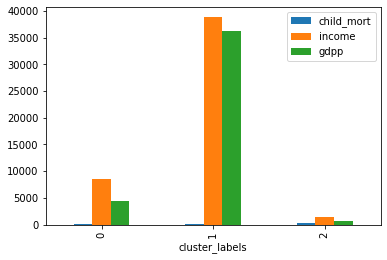

In [34]:
country[['child_mort','income','gdpp']].groupby(country['cluster_labels']).mean().plot(kind = 'bar')

In [35]:
country[country.cluster_labels != 1].sort_values(by = ['gdpp','child_mort','income'],
                                                                        ascending = [True,False,True,]).head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
26,Burundi,93.6,20.6052,26.7960,90.552,764.0,12.30,57.7,5.861,231,2,0
88,Liberia,89.3,62.4570,38.5860,302.802,700.0,5.47,60.8,5.020,327,2,0
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609.0,20.80,57.5,5.861,334,2,0
112,Niger,123.0,77.2560,17.9568,170.868,814.0,2.55,58.8,5.861,348,2,0
132,Sierra Leone,160.0,67.0320,52.2690,137.655,1220.0,17.20,55.0,5.200,399,2,0


## 4.4: Conclusion from Hierarchical Clustering

The five countries which are in the direst need of aid are the countries having the lowest gdpp, highest child_mort and the lowest income. Those 5 countries are as follows.
- Burundi
- Liberia
- Congo, Dem. Rep.
- Niger
- Sierra Leone

# 5. Conclusion

I found both the results from K Means and Hierarchical clustering to be same for the five countries which are in the direst need of aid. Those 5 countries are as follows.
- Burundi
- Liberia
- Congo, Dem. Rep.
- Niger
- Sierra Leone